In [1]:
!pip install opencv-python numpy datasets

     |████████████████████████████████| 54.7 MB 21.5 MB/s eta 0:00:01     |█████████████████▏              | 29.4 MB 20.4 MB/s eta 0:00:02


Get images 

In [2]:
from datasets import load_dataset

data = load_dataset('pinecone/image-set', split='train', revision='e7d39fc')
data 

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /Users/andiesamadoulougou/.cache/huggingface/datasets/pinecone___json/pinecone--image-set-47440dfcd4c1e47b/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51. Subsequent calls will reuse this data.


Dataset({
    features: ['image_bytes', 'image'],
    num_rows: 21
})

Decode 

In [3]:
from base64 import b64decode
import cv2
import numpy as np

def process_fn(sample):
    image_bytes = b64decode(sample['image_bytes'])
    image = cv2.imdecode(np.frombuffer(image_bytes, np.uint8), cv2.IMREAD_COLOR)
    return image

images = [process_fn(sample) for sample in data]

len(images)

21

Display some images 

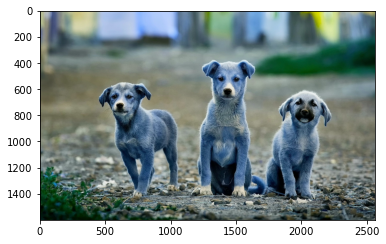

In [4]:
import matplotlib.pyplot as plt

plt.imshow(images[0])


Get real color for images 

In [5]:
shape = images[0].shape
shape, images[0][0, 0, :]



((1600, 2560, 3), array([165, 174, 134], dtype=uint8))

In [6]:
import numpy as np

rgb_image = np.flip(images[0], 2)

shape = rgb_image.shape
shape, rgb_image[0, 0, :]


((1600, 2560, 3), array([134, 174, 165], dtype=uint8))

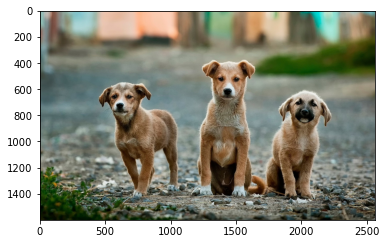

In [7]:
plt.imshow(rgb_image)


In [8]:
images[0][0, 0, :]

array([165, 174, 134], dtype=uint8)

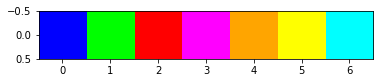

In [9]:
blue = [0, 0, 255]
green = [0, 255, 0]
red = [255, 0, 0]
violet = [255, 0, 255]
orange = [255, 165, 0]
yellow = [255, 255, 0]
cyan = [0, 255, 255]

colors = np.asarray([[blue, green, red, violet, orange, yellow, cyan]])

plt.imshow(colors)


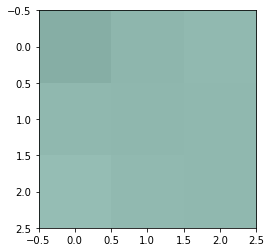

In [10]:
plt.imshow(rgb_image[:3, :3, :])


In [11]:
image_vector = rgb_image.reshape(1, -1, 3)
image_vector.shape


(1, 4096000, 3)

In [12]:
red = image_vector[0, :, 0]
green = image_vector[0, :, 1]
blue = image_vector[0, :, 2]

red.shape, green.shape, blue.shape


((4096000,), (4096000,), (4096000,))

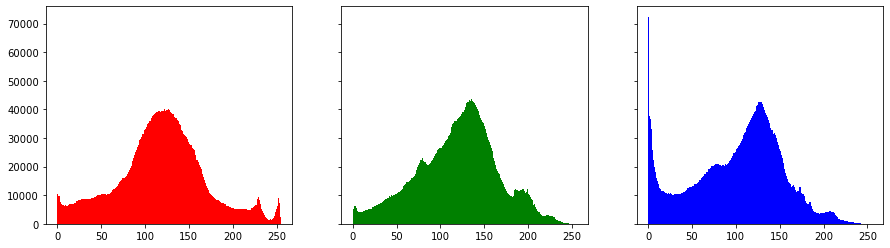

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
axs[0].hist(red, bins=256, color='r')
axs[1].hist(green, bins=256, color='g')
axs[2].hist(blue, bins=256, color='b')
plt.show()


In [14]:
def build_histogram(image, bins=256):
    # convert from BGR to RGB
    rgb_image = np.flip(image, 2)
    # show the image
    plt.imshow(rgb_image)
    # convert to a vector
    image_vector = rgb_image.reshape(1, -1, 3)
    # break into given number of bins
    div = 256 / bins
    bins_vector = (image_vector / div).astype(int)
    # get the red, green, and blue channels
    red = bins_vector[0, :, 0]
    green = bins_vector[0, :, 1]
    blue = bins_vector[0, :, 2]
    # build the histograms and display
    fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
    axs[0].hist(red, bins=bins, color='r')
    axs[1].hist(green, bins=bins, color='g')
    axs[2].hist(blue, bins=bins, color='b')
    plt.show()


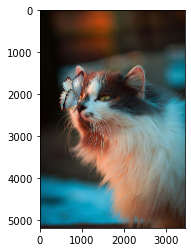

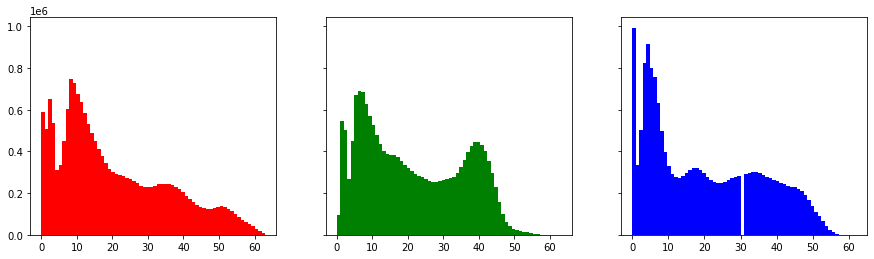

In [18]:
# we will see a lot of blue in this image, and it shows
# as high counts in high values in the blue histogram
build_histogram(images[4], 64)


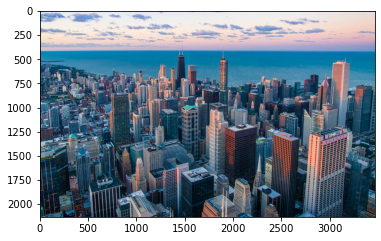

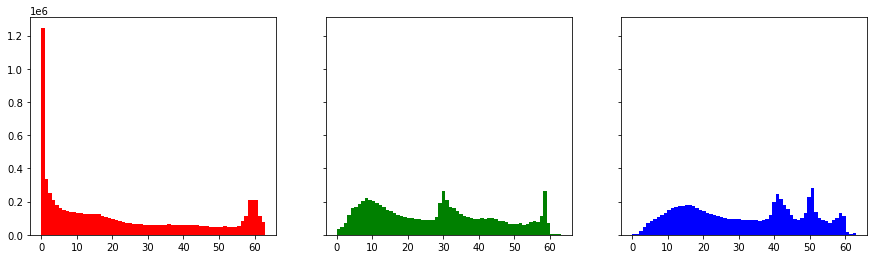

In [17]:
# very little blue in this image, and it shows as high counts in *low* values
# of the blue histogram
build_histogram(images[6], 64)


OpenCV 

In [19]:
red_hist = cv2.calcHist(
    [images[5]], [2], None, [64], [0, 256]
)
green_hist = cv2.calcHist(
    [images[5]], [1], None, [64], [0, 256]
)
blue_hist = cv2.calcHist(
    [images[5]], [0], None, [64], [0, 256]
)

red_hist.shape


(64, 1)

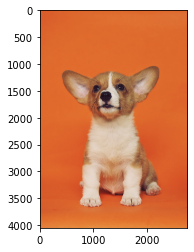

In [23]:
# convert from BGR to RGB
rgb_image = np.flip(images[5], 2)
# show the image
plt.imshow(rgb_image)

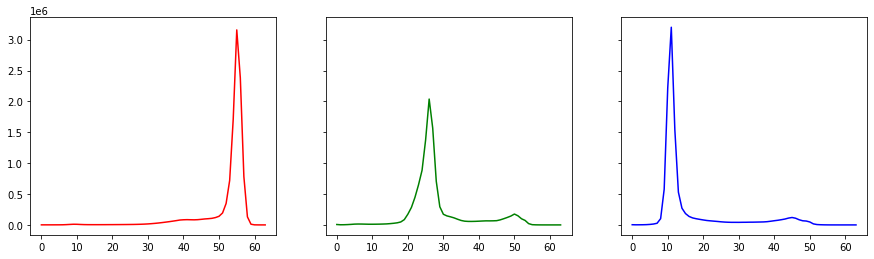

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
axs[0].plot(red_hist, color='r')
axs[1].plot(green_hist, color='g')
axs[2].plot(blue_hist, color='b')
plt.show()


In [25]:
def get_vector(image, bins=32):
    red = cv2.calcHist(
        [image], [2], None, [bins], [0, 256]
    )
    green = cv2.calcHist(
        [image], [1], None, [bins], [0, 256]
    )
    blue = cv2.calcHist(
        [image], [0], None, [bins], [0, 256]
    )
    vector = np.concatenate([red, green, blue], axis=0)
    vector = vector.reshape(-1)
    return vector


In [26]:
vec = get_vector(images[0])
vec.shape


(96,)

In [27]:
# and do the same for the remainder of our images
image_vectors = []
for image in images:
    image_vectors.append(get_vector(image))


In [28]:
def cosine(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


In [29]:
# during visualization we use this array of RGB images
rgb_images = np.array([np.flip(image, 2) for image in images])

def search(idx, top_k=5):
    query_vector = image_vectors[idx]
    distances = []
    for _, vector in enumerate(image_vectors):
        distances.append(cosine(query_vector, vector))
    # get top k most similar images
    top_idx = np.argpartition(distances, -top_k)[-top_k:]
    return top_idx


/var/folders/cr/c64r39nj2yb76nshsx9nxdlr0000gn/T/ipykernel_2499/1580453540.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  rgb_images = np.array([np.flip(image, 2) for image in images])


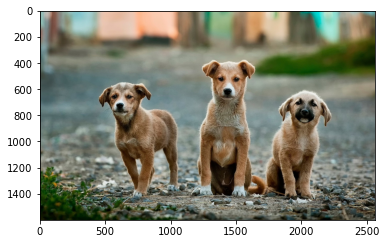

In [34]:
resultS = search(0)
plt.imshow(np.flip(images[0],2))

In [37]:
resultS

array([ 3, 18, 14, 15,  0])

3


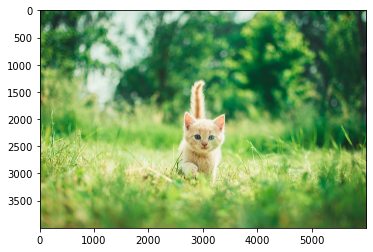

18


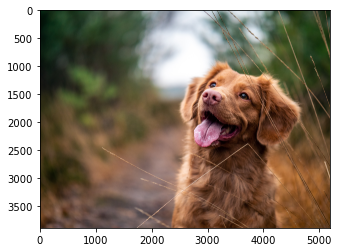

14


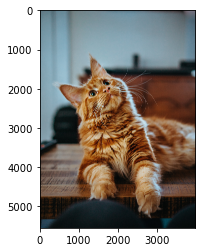

15


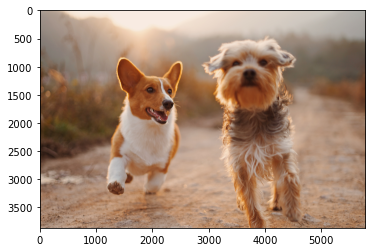

0


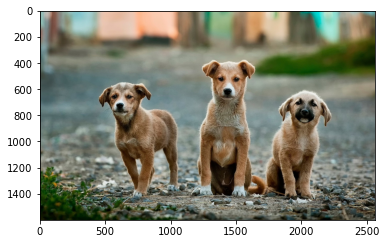

In [49]:
for x in range(len(resultS)):
    value = resultS[x]
    print(value)
    plt.imshow(np.flip(images[value],2))
    plt.show()

In [50]:
image_vectors[0]

array([6.34810e+04, 5.26470e+04, 5.87230e+04, 6.81270e+04, 7.01720e+04,
       7.66610e+04, 8.26060e+04, 8.57720e+04, 1.05261e+05, 1.27956e+05,
       1.60131e+05, 2.17486e+05, 2.61532e+05, 2.96223e+05, 3.13777e+05,
       3.18575e+05, 3.07208e+05, 2.77312e+05, 2.39087e+05, 2.04655e+05,
       1.55347e+05, 1.00099e+05, 7.22740e+04, 5.94760e+04, 4.88070e+04,
       4.22500e+04, 4.18670e+04, 4.04780e+04, 5.86020e+04, 3.16430e+04,
       1.22070e+04, 4.55580e+04, 4.21420e+04, 3.51870e+04, 4.26200e+04,
       5.27950e+04, 6.51480e+04, 7.75380e+04, 8.80170e+04, 1.08919e+05,
       1.27895e+05, 1.66244e+05, 1.70531e+05, 1.82623e+05, 2.11974e+05,
       2.37997e+05, 2.81121e+05, 3.04962e+05, 3.38439e+05, 3.32794e+05,
       2.87919e+05, 2.31689e+05, 1.62457e+05, 1.13621e+05, 8.10210e+04,
       9.27370e+04, 9.39110e+04, 7.20230e+04, 3.75610e+04, 2.40360e+04,
       2.08780e+04, 8.66800e+03, 2.28500e+03, 2.48000e+02, 2.77393e+05,
       1.11786e+05, 8.76760e+04, 8.25150e+04, 8.46650e+04, 9.579